In [16]:
import pandas as pd
import os
import re
import json
import yaml
from glob import glob
from tqdm import tqdm
from pprint import pprint
import torch
import pytorch_lightning as pl
from rouge import Rouge # 모델의 성능을 평가하기 위한 라이브러리입니다.
import numpy as np
from torch.utils.data import Dataset , DataLoader
from transformers import AutoTokenizer, BartForConditionalGeneration, BartConfig
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
from collections import Counter
import wandb # 모델 학습 과정을 손쉽게 Tracking하고, 시각화할 수 있는 라이브러리입니다.

In [17]:
model_name = "digit82/kobart-summarization"
tokenizer = AutoTokenizer.from_pretrained(model_name)


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [18]:
train_data = pd.read_csv("../data/train.csv")
val_data = pd.read_csv("../data/dev.csv")
test_data = pd.read_csv("../data/test.csv")


In [19]:
train_data.shape

(12457, 4)

In [20]:
print(f"{train_data.shape[0]} {train_data['topic'].unique().__len__()}")
print(f"{val_data.shape[0]} {val_data['topic'].unique().__len__()}")

12457 9235
499 475


In [36]:
topic_count_df = train_data['topic'].value_counts().reset_index(name='count')
val_count_df = val_data['topic'].value_counts().reset_index(name='count')

In [37]:
topic_count_df

,topic,count
0,음식 주문,130
1,취업 면접,109
2,길 안내,66
3,호텔 체크인,40
4,아파트 임대,30
...,...,...
9230,애정,1
9231,독서 토론,1
9232,술자리,1
9233,결혼과 관계 종료,1


In [38]:
val_count_df

,topic,count
0,호텔 방 예약,5
1,길 안내,4
2,취업 면접,4
3,음식 주문,4
4,신발 구매,2
...,...,...
470,음악 활동,1
471,나노미터 설명,1
472,감사 전화,1
473,옷 쇼핑과 교환,1


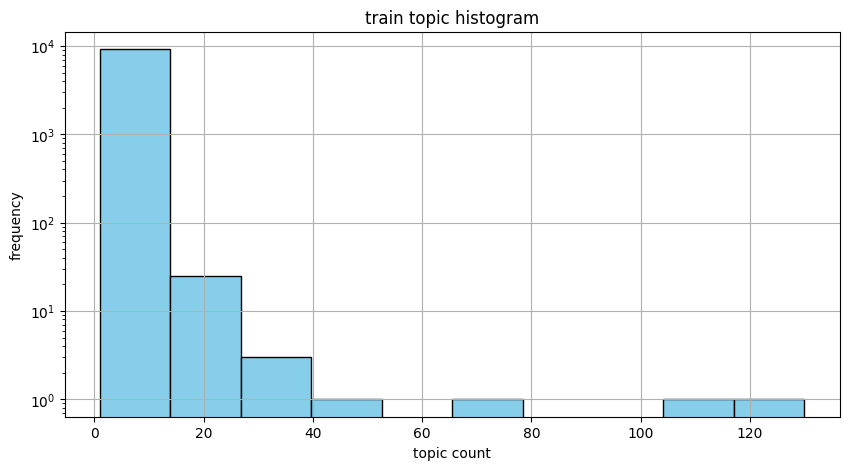

In [22]:
train_topic_count = list(Counter(train_data['topic']).values())
import numpy as np
import matplotlib.pyplot as plt
np.percentile(train_topic_count, 98)
plt.figure(figsize=(10, 5))
plt.hist(train_topic_count, bins=10, color='skyblue', edgecolor='black', log=True)
plt.title("train topic histogram")
plt.xlabel("topic count")
plt.ylabel("frequency")
plt.grid(True)
plt.show()

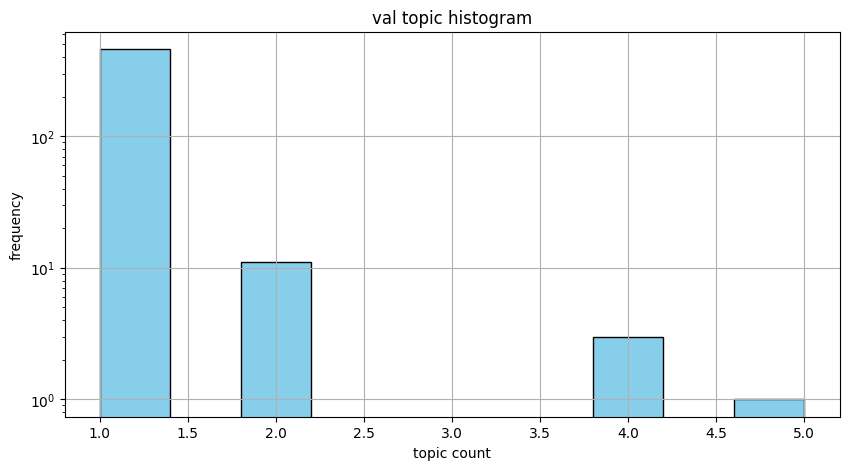

In [23]:
val_topic_count = list(Counter(val_data['topic']).values())
import numpy as np
import matplotlib.pyplot as plt
np.percentile(val_topic_count, 98)
plt.figure(figsize=(10, 5))
plt.hist(val_topic_count, bins=10, color='skyblue', edgecolor='black', log=True)
plt.title("val topic histogram")
plt.xlabel("topic count")
plt.ylabel("frequency")
plt.grid(True)
plt.show()

In [24]:
topic_total = Counter(train_data['topic'].tolist()+val_data['topic'].tolist())

In [25]:
# 대화별 화자 추출

train_person = []
for i in train_data['dialogue']:
    train_person.append([j.split(':')[0] for j in i.split('\n')])

val_person = []
for i in val_data['dialogue']:
    val_person.append([j.split(':')[0] for j in i.split('\n')])

test_person = []
for i in test_data['dialogue']:
    test_person.append([j.split(':')[0] for j in i.split('\n')])


In [26]:
# 참여자수 별 대화 갯수
print(f'train {Counter([len(set(i)) for i in train_person])}')
print(f'val {Counter([len(set(i)) for i in val_person])}')
print(f'test {Counter([len(set(i)) for i in test_person])}')


train Counter({2: 12326, 3: 107, 1: 10, 4: 9, 5: 3, 6: 1, 7: 1})
val Counter({2: 494, 3: 4, 4: 1})
test Counter({2: 493, 3: 4, 1: 2})


In [43]:
a = pd.DataFrame({"person_count":[len(set(i)) for i in train_person]}).value_counts().reset_index(name='train_count')
b = pd.DataFrame({"person_count":[len(set(i)) for i in val_person]}).value_counts().reset_index(name='val_count')
c = pd.DataFrame({"person_count":[len(set(i)) for i in test_person]}).value_counts().reset_index(name='test_count')

pd.merge(a,b,on='person_count',how='left').merge(c,on='person_count',how='left')

,person_count,train_count,val_count,test_count
0,2,12326,494.0,493.0
1,3,107,4.0,4.0
2,1,10,NaN,2.0
3,4,9,1.0,NaN
4,5,3,NaN,NaN
5,6,1,NaN,NaN
6,7,1,NaN,NaN


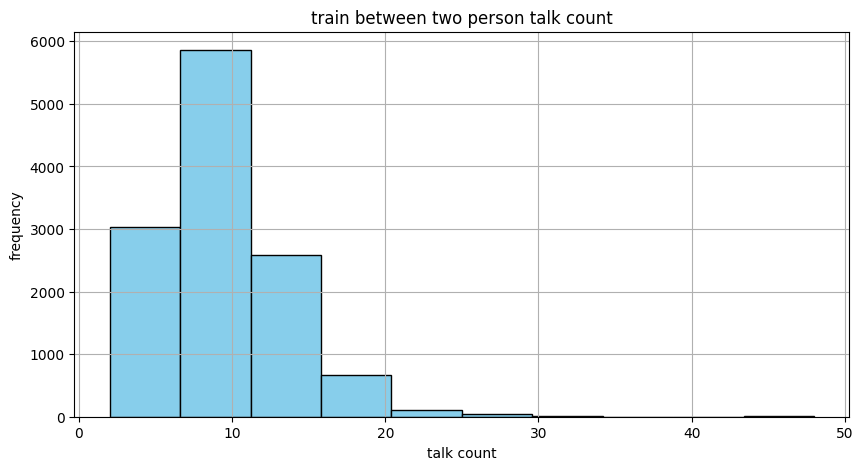

In [27]:
two_train_person = []
for i in train_person:
    if len(set(i)) == 2:
        two_train_person.append(len(i))
import numpy as np
import matplotlib.pyplot as plt
np.percentile(two_train_person, 98)
plt.figure(figsize=(10, 5))
plt.hist(two_train_person, bins=10, color='skyblue', edgecolor='black')
plt.title("train between two person talk count")
plt.xlabel("talk count")
plt.ylabel("frequency")
plt.grid(True)
plt.show()

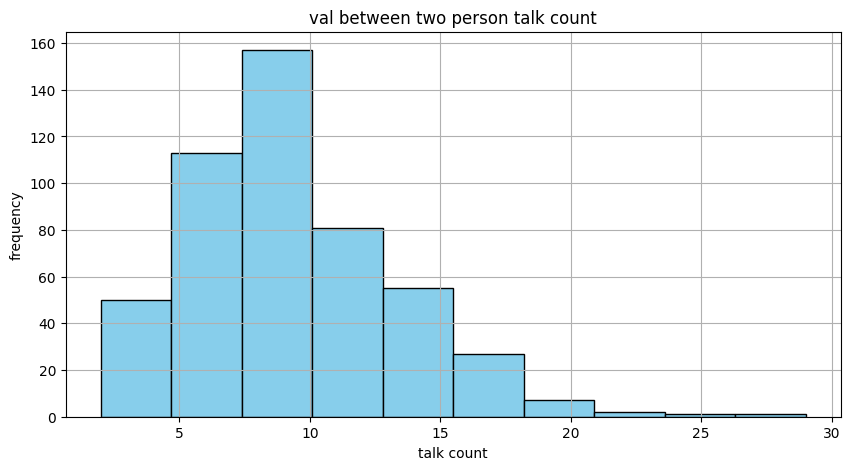

In [28]:
two_val_person = []
for i in val_person:
    if len(set(i)) == 2:
        two_val_person.append(len(i))
import numpy as np
import matplotlib.pyplot as plt
np.percentile(two_val_person, 98)
plt.figure(figsize=(10, 5))
plt.hist(two_val_person, bins=10, color='skyblue', edgecolor='black')
plt.title("val between two person talk count")
plt.xlabel("talk count")
plt.ylabel("frequency")
plt.grid(True)
plt.show()

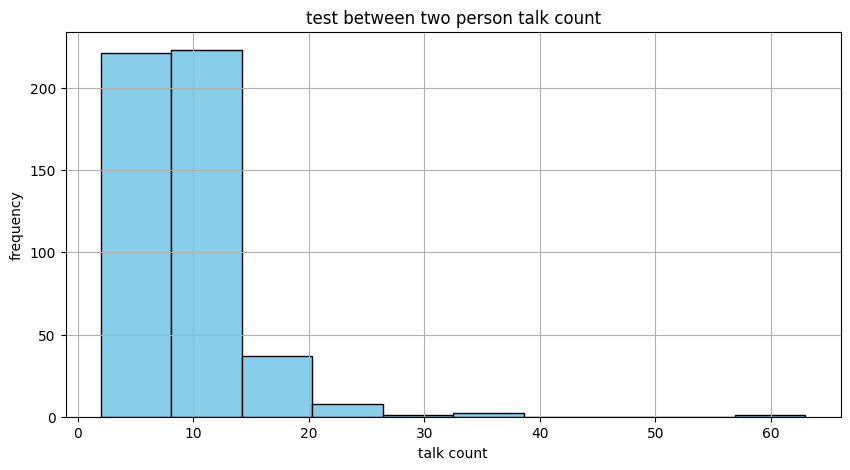

In [29]:
two_test_person = []
for i in test_person:
    if len(set(i)) == 2:
        two_test_person.append(len(i))
import numpy as np
import matplotlib.pyplot as plt
np.percentile(two_test_person, 98)
plt.figure(figsize=(10, 5))
plt.hist(two_test_person, bins=10, color='skyblue', edgecolor='black')
plt.title("test between two person talk count")
plt.xlabel("talk count")
plt.ylabel("frequency")
plt.grid(True)
plt.show()

In [30]:
# 2명의 화자 대화 횟수
print(f'train {Counter(two_train_person)}')
print(f'val {Counter(two_val_person)}')
print(f'test {Counter(two_test_person)}')

train Counter({10: 1513, 8: 1459, 12: 1328, 6: 1182, 9: 1114, 7: 973, 11: 802, 4: 789, 5: 706, 13: 496, 14: 493, 15: 262, 16: 262, 2: 230, 17: 150, 3: 127, 18: 110, 20: 80, 19: 61, 21: 43, 22: 29, 24: 22, 23: 21, 26: 13, 25: 12, 29: 10, 28: 9, 30: 7, 27: 7, 32: 5, 31: 3, 48: 2, 38: 1, 44: 1, 39: 1, 33: 1, 45: 1, 34: 1})
val Counter({8: 67, 12: 59, 10: 47, 9: 43, 6: 42, 4: 39, 5: 39, 7: 32, 11: 22, 14: 22, 13: 18, 15: 15, 16: 15, 17: 8, 2: 7, 3: 4, 19: 4, 18: 4, 20: 3, 25: 1, 29: 1, 23: 1, 21: 1})
test Counter({8: 59, 10: 54, 9: 47, 7: 44, 6: 43, 12: 42, 5: 35, 11: 34, 4: 29, 13: 23, 14: 23, 15: 17, 16: 8, 3: 6, 2: 5, 19: 4, 18: 4, 17: 3, 22: 2, 26: 2, 37: 1, 23: 1, 25: 1, 21: 1, 28: 1, 20: 1, 63: 1, 24: 1, 35: 1})


In [31]:
train_summary_len = [len(i) for i in train_data['summary']]
val_summary_len = [len(i) for i in val_data['summary']]

print(f'train {Counter(train_summary_len)}')
print(f'val {Counter(val_summary_len)}')

train Counter({72: 198, 63: 188, 71: 181, 59: 179, 60: 175, 66: 175, 57: 174, 62: 174, 78: 170, 67: 169, 61: 168, 80: 165, 68: 165, 56: 165, 79: 165, 70: 163, 65: 161, 64: 161, 84: 159, 69: 159, 54: 158, 58: 157, 77: 156, 55: 155, 73: 153, 76: 152, 86: 152, 85: 150, 87: 149, 93: 149, 53: 148, 74: 146, 89: 144, 75: 144, 82: 143, 97: 142, 52: 141, 50: 141, 83: 139, 81: 136, 49: 135, 90: 134, 88: 134, 51: 134, 91: 133, 92: 129, 47: 126, 94: 123, 95: 122, 100: 122, 98: 120, 101: 117, 48: 117, 45: 106, 99: 105, 46: 104, 104: 104, 44: 103, 96: 102, 109: 96, 105: 95, 107: 95, 102: 95, 103: 94, 106: 92, 111: 90, 43: 87, 108: 86, 41: 80, 110: 78, 118: 77, 116: 74, 112: 72, 121: 72, 115: 71, 114: 70, 123: 69, 119: 69, 124: 67, 120: 67, 40: 67, 42: 62, 122: 61, 39: 59, 113: 58, 117: 57, 125: 56, 127: 50, 126: 49, 128: 45, 130: 43, 131: 43, 129: 42, 144: 41, 38: 41, 37: 40, 135: 40, 132: 39, 138: 39, 137: 38, 134: 37, 133: 35, 141: 35, 36: 34, 136: 34, 35: 33, 140: 33, 151: 32, 145: 30, 139: 30, 1

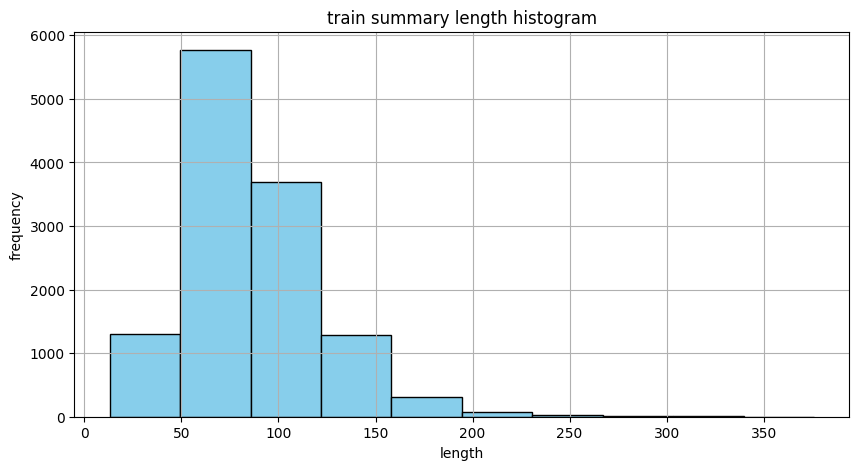

In [32]:
import numpy as np
import matplotlib.pyplot as plt
np.percentile(train_summary_len, 98)
plt.figure(figsize=(10, 5))
plt.hist(train_summary_len, bins=10, color='skyblue', edgecolor='black')
plt.title("train summary length histogram")
plt.xlabel("length")
plt.ylabel("frequency")
plt.grid(True)
plt.show()

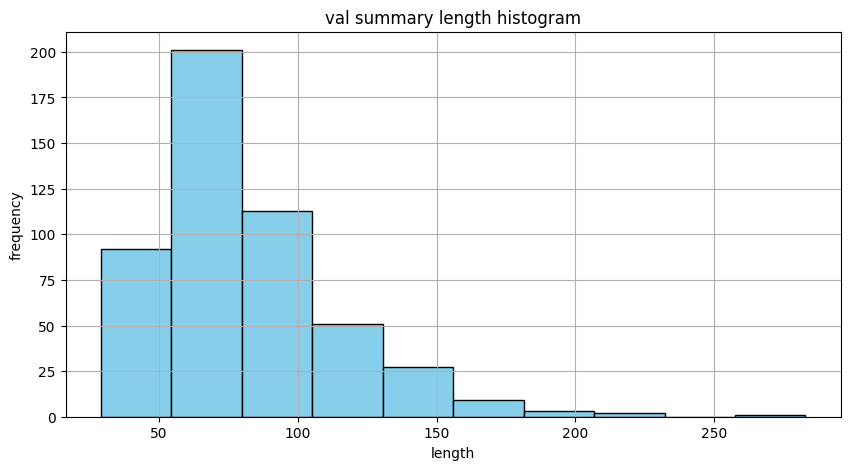

In [33]:
import numpy as np
import matplotlib.pyplot as plt
np.percentile(val_summary_len, 98)
plt.figure(figsize=(10, 5))
plt.hist(val_summary_len, bins=10, color='skyblue', edgecolor='black')
plt.title("val summary length histogram")
plt.xlabel("length")
plt.ylabel("frequency")
plt.grid(True)
plt.show()

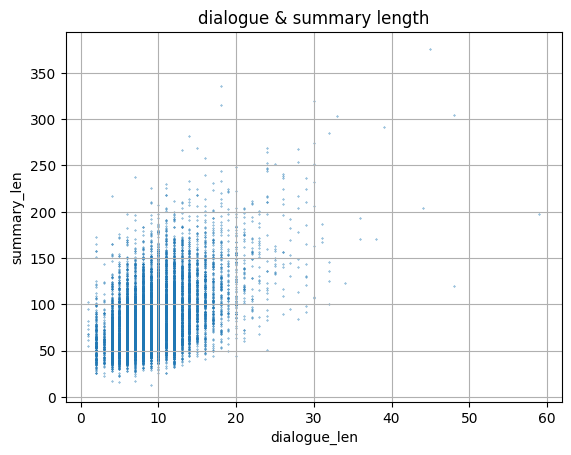

In [35]:
train_word_len_df = pd.DataFrame([{'dialogue_len':len(i),'summary_len':len(v)} for i,v in zip(train_person,train_data['summary'])])
val_word_len_df = pd.DataFrame([{'dialogue_len':len(i),'summary_len':len(v)} for i,v in zip(val_person,train_data['summary'])])
import matplotlib.pyplot as plt
plt.scatter(train_word_len_df['dialogue_len'], train_word_len_df['summary_len'],s=0.1)
plt.xlabel("dialogue_len")
plt.ylabel("summary_len")
plt.title("dialogue & summary length")
plt.grid(True)
plt.show()

In [41]:
correlation = train_word_len_df['dialogue_len'].corr(train_word_len_df['summary_len'])
print("문자 길이 상관계수 (피어슨):", correlation)

문자 길이 상관계수 (피어슨): 0.48041325902248583


In [42]:
import random
summary_len_count = Counter(train_summary_len+val_summary_len)
summary_turns = list(summary_len_count.keys())
summary_frequencies = list(summary_len_count.values())



In [43]:
import random
topoic_max = 3

two_train_person_count = Counter(two_train_person)
turns = list(two_train_person_count.keys())
frequencies = list(two_train_person_count.values())
create_topic = dict()
for topic_name,topic_count in topic_total.items():
    dialogue_person = []

    create_count = random.choices(turns, weights=frequencies, k=topoic_max-topic_count)
    create_person = [["#Person1#" if j%2==0 else "#Person2#" for j in range(i)] for i in create_count]

    if create_person:
        create_topic[topic_name] = create_person
    


In [44]:
topic_name = '건강검진'
values = create_topic[topic_name]
len(values)

2

In [45]:
create_topic.keys().__len__()

9028

In [46]:
topic_name = '건강검진'
values = create_topic[topic_name][23]
create_word_len = random.choices(summary_turns, weights=summary_frequencies, k=1)[0]
tolk = "\n".join([f"{i} : (대화 내용)" for i in values])
prompt = f"""
너는 주어진 주제에 대한 가상 대화를 생성하고 요약하는 AI야.

# 지시사항
1. 아래 주어진 **주제**에 대해 #Person1#과 #Person2#가 대화하는 내용을 생성해 줘.
2. 대화가 끝나면, 전체 대화 내용을 {create_word_len}자 이내로 요약해 줘.
4. 아래 **출력 형식**을 반드시 지켜줘.

# 주제
{topic_name}

# 출력 형식
{tolk}

## 요약 ##
(요약 내용)
"""
print(prompt)

IndexError: list index out of range

In [47]:
data = []
for topic_name,tolks in create_topic.items():
    for tolk in tolks:
        create_word_len = random.choices(summary_turns, weights=summary_frequencies, k=1)[0]
        tolk = "\n".join([f'        "{i}: (대화 내용)"' for i in tolk])
        prompt = f"""
너는 주어진 주제에 대한 가상 대화를 생성하고 요약하는 AI야.

# 지시사항
1. 아래 주어진 **주제**에 대해 #Person1#과 #Person2#가 대화하는 내용을 생성해 줘.
2. 대화가 끝나면, 전체 대화 내용을 {create_word_len}자 이내로 요약해 줘.
3. 요약 방식은 사건 중심으로 요약해줘.
4. 화자 태그를 유지한 상태로 요약해줘.
5. **→, ·, : 등의 기호나 요약체 표현은 사용하지 마세요.**  
6. 아래 **출력 형식**을 반드시 지켜줘.

# 주제
{topic_name}

# 출력 형식
{{
    "dialogue1":[
{tolk}
        ],
    "summary1":"(요약 내용)",
    
    "dialogue2":[
{tolk}
    ],
    "summary2":"(요약 내용)",

    "dialogue3":[
{tolk}
    ],
    "summary3":"(요약 내용)",
}}

"""
        data.append({'topic_name':topic_name,'prompt':prompt,'tolk_count':len(tolks),'create_word_len':create_word_len})

In [48]:
output_data = pd.DataFrame(data)
output_data['output'] = [None] * len(output_data)
output_data = output_data.sample(frac=1).reset_index(drop=True)
output_data.to_csv("output_data_v2.csv", index=False)
output_data.shape

(17331, 5)

In [ ]:
train_data['token_count_dialogue'] = train_data['dialogue'].apply(lambda x: len(tokenizer.encode(x)))
train_data['token_count_summary'] = train_data['summary'].apply(lambda x: len(tokenizer.encode(x)))
val_data['token_count_dialogue'] = val_data['dialogue'].apply(lambda x: len(tokenizer.encode(x)))
val_data['token_count_summary'] = val_data['summary'].apply(lambda x: len(tokenizer.encode(x)))
test_data['token_count_dialogue'] = test_data['dialogue'].apply(lambda x: len(tokenizer.encode(x)))


In [ ]:
print('train_data token_count_dialogue 99 percentile : ',np.percentile(train_data['token_count_dialogue'], 99))
print('train_data token_count_summary 99 percentile : ',np.percentile(train_data['token_count_summary'], 99))
print('val_data token_count_dialogue 99 percentile : ',np.percentile(val_data['token_count_dialogue'], 99))
print('val_data token_count_summary 99 percentile : ',np.percentile(val_data['token_count_summary'], 99))
print('test_data token_count_dialogue 99 percentile : ',np.percentile(test_data['token_count_dialogue'], 99))

In [ ]:
train_data = train_data[(train_data['token_count_dialogue'] <= 530) & (train_data['token_count_summary'] <= 100)]
val_data = val_data[(val_data['token_count_dialogue'] <= 530) & (val_data['token_count_summary'] <= 100)]

train_data.to_csv("../size_cut_data/train.csv", index=False)
val_data.to_csv("../size_cut_data/dev.csv", index=False)

In [ ]:
train_encoded = train_data['dialogue'].apply(tokenizer.encode)
train_summary_encoded = train_data['summary'].apply(tokenizer.encode)
test_encoded = test_data['dialogue'].apply(tokenizer.encode)
mean = lambda x: sum(x) / len(x)

print('train token max length : ',max([len(i) for i in train_encoded]))
print('train token min length : ',min([len(i) for i in train_encoded]))
print('train token mean length : ',mean([len(i) for i in train_encoded]))
print('train summary token max length : ',max([len(i) for i in train_summary_encoded]))
print('train summary token min length : ',min([len(i) for i in train_summary_encoded]))
print('train summary token mean length : ',mean([len(i) for i in train_summary_encoded]))
print('test token max length : ',max([len(i) for i in test_encoded]))
print('test token min length : ',min([len(i) for i in test_encoded]))
print('test token mean length : ',mean([len(i) for i in test_encoded]))



